# Average Price of Books in Colombia

The main objective of this project, is to calculate the average price of new printed books and ebooks in Colombia. To do so, it takes as reference one of the best library online in Colombia - Libreria de la U (https://www.libreriadelau.com/) - to scrape thousends of book items.

Scraping Date: March 2020

In [1]:
import requests
import pandas as pd
from scrapy.selector import Selector
from scrapy.http import TextResponse
import re
import unidecode
import json

In [9]:
# List of Edition year

# Star Url
request = requests.get('https://www.libreriadelau.com/'
                       'temas-varios/?O=OrderByReleaseDateDESC') 

response = TextResponse(request.url, body=request.text, encoding='utf-8')
num = response.xpath("//ul[@class='Año de Edición  Atributos LU']/li/a/@title").extract()

num_ediciones = list(dict.fromkeys(num)) # removiendo duplicados
print(num_ediciones)
print('\Resultados:',len(num_ediciones))

# Results for each Edition Year
year = response.xpath("//ul[@class='Año de Edición  Atributos LU']/li/a/text()").re(r'\(([^)]+)')
yearm = list(dict.fromkeys(year)) # Remove duplicates in list

ediciones=[]
for i in yearm:
    ediciones.append(int(i))
print('\nResultados por Edición:','\nTotales:',sum(ediciones), '\nMax:',max(ediciones),'\n')

ediciones.sort(reverse=True)

print(ediciones)

In [10]:
# iteration

# Page results structure
desde = 0
hasta = 19

num_ediciones = num_ediciones[41:] # Slice the list if it's necessary

# Variables 
autor,editorial,edicion,pag,ISBN,tipo,formato,titulo,categoria,precio,file,size,peso,tamano,acabado,link = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

while desde<=max(ediciones) and hasta<=(max(ediciones)+19):
    
    for i in num_ediciones:
        
        # Change book Category in the link when repeating the process
        request = requests.get('https://www.libreriadelau.com/api/catalog_system/pub/products/search/'
            'temas-varios/'+i+'?O=OrderByPriceDESC&map=c,'
           'c,specificationFilter_71&_from='+str(desde)+'&_to='+str(hasta))

        response = TextResponse(request.url, body=request.text, encoding='utf-8')
        
        try:
            data = json.loads(response.text)
        
            if len(data)==0:
                pass

            else:
                for i in data:
                    try: autor.append(i['Autor'][0])
                    except Exception: autor.append(None)

                    try: editorial.append(i['Editorial'][0])
                    except Exception: editorial.append(None)

                    try: edicion.append(i['Año de Edición'][0])
                    except Exception: edicion.append(None)

                    try: pag.append(i['Núm. Páginas'][0])
                    except Exception: pag.append(None)

                    try: ISBN.append(i['ISXN'][0])
                    except Exception: ISBN.append(None)

                    try: tipo.append(i['Tipo'][0])
                    except Exception: tipo.append(None)

                    try: formato.append(i['items'][0]['Formato'][0])
                    except Exception: formato.append(None)

                    try: titulo.append(i['Título'][0])
                    except Exception: titulo.append(None)

                    try: categoria.append(i['categories'][0])
                    except Exception: categoria.append(None)

                    try: precio.append(i['items'][0]['sellers'][0]['commertialOffer']['ListPrice'])
                    except Exception: precio.append(None)

                    try: file.append(i['Formato Electrónico (Virtual)'][0])
                    except Exception:file.append(None)

                    try: size.append(i['Tamaño Archivo (Virtual)'][0])
                    except Exception: size.append(None)

                    try: peso.append(i['Peso (Físico)'][0])
                    except Exception: peso.append(None)

                    try: tamano.append(i['Tamaño (Físico)'][0])
                    except Exception: tamano.append(None)

                    try: acabado.append(i['Acabado (Físico)'][0])
                    except Exception: acabado.append(None)

                    try: link.append(i['link'])
                    except Exception: link.append(None)

        except Exception:
            pass
        
    desde += 20
    hasta += 20

# Load Data in Pandas
f = pd.DataFrame(data=[autor,editorial,edicion,pag,ISBN,tipo,formato,titulo,categoria,precio,file,size,peso,tamano,acabado,link], index=None)
df=f.transpose()
df.columns=['Autor','Editorial','Edicion','Paginas','ISBN','Tipo','Formato','Titulo','Categoria','Precio','File','Size-MB','Peso','Tamaño','Acabado','Link']

In [11]:
# Export/Import
df.to_csv(r'C:\Users\AndyJ\Desktop\App Libros\Libreria\temas-varios3.csv')

In [1]:
# Import CSVs as one

import pandas as pd
import glob

path = r'C:\Users\AndyJ\Desktop\App Libros\Libreria'

all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, dtype={
        'Acabado':'str','Autor':'str','Categoria':'str','Edicion':'str','Editorial':'str','File':'str','Formato':'str',
        'ISBN':'str','Link':'str','Paginas':'float64','Peso':'float64','Precio':'float64','Tamaño':'str','Tipo':'str',
        'Tiutlo':'str'},low_memory=False)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.tail(2)

,Acabado,Autor,Categoria,Edicion,Editorial,File,Formato,ISBN,Link,Paginas,Peso,Precio,Size-MB,Tamaño,Tipo,Titulo,Unnamed: 0
380153,NaN,NaN,/Veterinaria y Zootecnia/,1900,Distribuciones Agapea Libros Urgentes,NaN,Libro Importado,9788494404856,https://www.libreriadelau.com/ag-los-vencejos-...,282.0,367.0,0.0,NaN,0 x 0 cm,Libro Importado,NaN,883.0
380154,NaN,"Produmedios, Producción de Medios de Comunicación",/Veterinaria y Zootecnia/,1900,NaN,NaN,DVD,N. D.,https://www.libreriadelau.com/las-garrapatas-y...,NaN,90.0,0.0,NaN,13.5 x 19 cm,DVD,Las garrapatas y su ciclo de vida,884.0


In [2]:
# Removing Column
df.drop(columns='Unnamed: 0', inplace=True)

# Removing results: price==0
df.drop(df[df.Precio<=10000].index,inplace=True)
df.drop(df[df.Precio>=300000].index,inplace=True)

# Removing duplicates
df.drop_duplicates(keep='first', inplace=True)

# Reset Index
df.reset_index(drop=True, inplace=True)

# Spliting category
df[['Cat0','Cat','Gen','Gen0']] = df.Categoria.str.split("/",expand=True)

# Removing Columns
df.drop(columns=['Cat0','Gen0'], inplace=True)

df.tail(2)

,Acabado,Autor,Categoria,Edicion,Editorial,File,Formato,ISBN,Link,Paginas,Peso,Precio,Size-MB,Tamaño,Tipo,Titulo,Cat,Gen
167868,NaN,Hogares Juveniles Campesinos,/Veterinaria y Zootecnia/,1900,NaN,NaN,DVD,7777777777732,https://www.libreriadelau.com/cerdos-reproducc...,0.0,110.0,20000.0,NaN,13.5 x 19 cm,DVD,Cerdos. Reproducción,Veterinaria y Zootecnia,
167869,NaN,Alexandra Horowitz,/Veterinaria y Zootecnia/,2013,NaN,EPUB,eBook,9788498679663,https://www.libreriadelau.com/lib-en-la-mente-...,352.0,0.0,16600.0,0.46,NaN,eBook,En la mente de un perro,Veterinaria y Zootecnia,


In [3]:
# Ebook's Average Size 
df['Size-MB'].mean()

4.232058082877649

In [5]:
# Average price by Format
df.groupby('Formato').agg(['mean','count'])['Precio'].sort_values('count', ascending=False)

,mean,count
Formato,,
eBook,29784.759258,67213
Libro Importado,63914.236179,55949
Libro Impreso,53093.765744,26454
Norma Técnica Colombiana,48709.915716,6051
Revista,23442.315470,989
Impreso Bajo Demanda,63607.676349,482
Documento de Investigación,60461.250000,320
Audiolibro,25099.264706,136
DVD,22965.289256,121


In [192]:
impreso = (df['Formato']=='Libro Impreso') | (df['Formato']=='Libro Importado')
ebook = (df['Formato']=='eBook')

In [331]:
# Mode Price of Printed Books
df[impreso].Precio.mode()

0    30000.0
dtype: float64

In [215]:
# Average price by Category
df[impreso].groupby('Cat').agg(['mean','count'])['Precio'].sort_values(by='mean', ascending=False)

,mean,count
Cat,,
Veterinaria y Zootecnia,84993.925234,214
Libros sobre Informática,80794.687500,320
Libros sobre Ciencias de la Salud,78081.029975,1201
Libros de Educación Física y Deporte,75322.289157,498
Libros de Ingeniería,73485.085694,1412
Libros de Arte Arquitectura y Diseño,70650.068618,2186
Libros de Derecho,68710.144129,2921
Libros sobre Ciencias Naturales,68223.986486,888
Libros de Biografías y Autobiografías,65663.612565,382


In [216]:
# Ebook's Average price by Category
df[ebook].groupby('Cat').agg(['mean','count'])['Precio'].sort_values(by='mean', ascending=False)

,mean,count
Cat,,
Libros de Derecho,45857.573290,1228
Libros sobre Ciencias de la Salud,43993.908046,870
Libros de Ingeniería,43482.477341,331
Libros de Educación Física y Deporte,38912.652068,411
Libros sobre Ciencias Políticas,38715.293342,1517
Veterinaria y Zootecnia,38251.376147,109
Libros de Arte Arquitectura y Diseño,36514.021739,1380
Libros de Lingüística y Lenguas,36084.447476,733
Libros sobre Ciencias Naturales,34179.963810,525


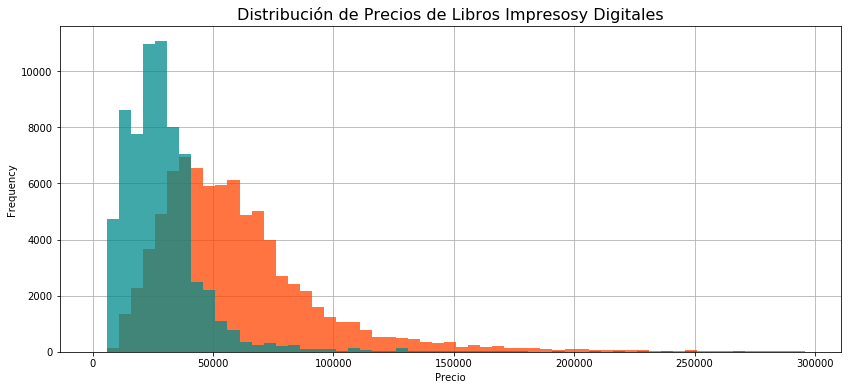

In [326]:
# Price Distribution
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import seaborn
%matplotlib inline

bin_values = np.arange(start=1000, stop=300000, step=5000)
df[impreso].Precio.plot.hist(bins=bin_values, figsize=[14,6], facecolor='orangered', alpha=0.75, zorder=2)
df[ebook].Precio.plot.hist(bins=bin_values, figsize=[14,6], facecolor='darkcyan', alpha=0.75,zorder=2)
plt.grid(True, zorder=0)
plt.xlabel('Precio')
plt.title('Distribución de Precios de Libros Impresosy Digitales', fontsize=16);

In [213]:
df[impreso].Precio.describe()

count     82403.000000
mean      60440.518901
std       35019.842480
min       10100.000000
25%       37200.000000
50%       53300.000000
75%       73000.000000
max      299900.000000
Name: Precio, dtype: float64

In [14]:
df[ebook].Precio.describe()

count     67213.000000
mean      29784.759258
std       20493.653868
min       10100.000000
25%       17900.000000
50%       26800.000000
75%       35300.000000
max      299900.000000
Name: Precio, dtype: float64

In [249]:
#  Average price by Cover
df[impreso].groupby('Acabado').agg(['mean','count'])['Precio'].sort_values(by='count', ascending=False)

,mean,count
Acabado,,
Tapa Rustica,53147.207861,15953
Tapa Dura,67208.461102,1761
Tapa de Tela,19900.000000,4
89,25000.000000,1
9.78959E+12,60000.000000,1
9.78988E+12,43000.000000,1
9780718086909,75000.000000,1
9788497616447,40000.000000,1
9789587784398,74000.000000,1


In [298]:
# Price comparation: Rustic vs Hard Cover

Rustica = 53147.2
Dura = 67208.5

round(67208.5/53147.2 - 1,3)

0.265

## Price comparation: Printed Book vs Ebook

In [151]:
fisico = df[df['Formato']=='Libro Impreso']
importado = df[df['Formato']=='Libro Importado']
digital = df[df['Formato']=='eBook']

In [166]:
table1 = pd.merge(fisico,digital, on=['Titulo'], how='inner',suffixes=('_fis', '_dig'))
table1['Comparativo'] = table1['Precio_dig']/table1['Precio_fis'] - 1

table2 = pd.merge(importado,digital, on=['Titulo'], how='inner',suffixes=('_fis', '_dig'))
table2['Comparativo'] = table2['Precio_dig']/table2['Precio_fis'] - 1

dfc = pd.concat(objs=[table1,table2], axis=0)

In [208]:
regla = (dfc['Comparativo']<0) & (dfc['Titulo'].notna()) & (dfc['Editorial_fis']==dfc['Editorial_dig']) & (dfc['Edicion_fis']==dfc['Edicion_dig'])


In [209]:
dfc[regla].Comparativo.describe()

count    1090.000000
mean       -0.373263
std         0.150990
min        -0.831579
25%        -0.467628
50%        -0.384478
75%        -0.268160
max        -0.003704
Name: Comparativo, dtype: float64

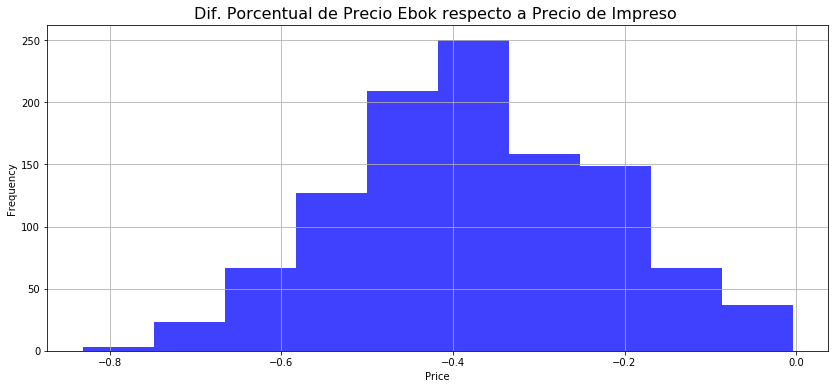

In [293]:
# bin_values = np.arange(start=1000, stop=300000, step=5000)
dfc[regla].Comparativo.plot.hist( figsize=[14,6], facecolor='blue', alpha=0.75)
plt.grid(True)
plt.xlabel('Price')
plt.title('Dif. Porcentual de Precio Ebok respecto a Precio de Impreso ', fontsize=16);

In [283]:
xl = df[impreso].groupby('Cat').agg(['mean'])['Precio'].sort_values(by='mean', ascending=False)
xe = df[ebook].groupby('Cat').agg(['mean'])['Precio'].sort_values(by='mean', ascending=False)

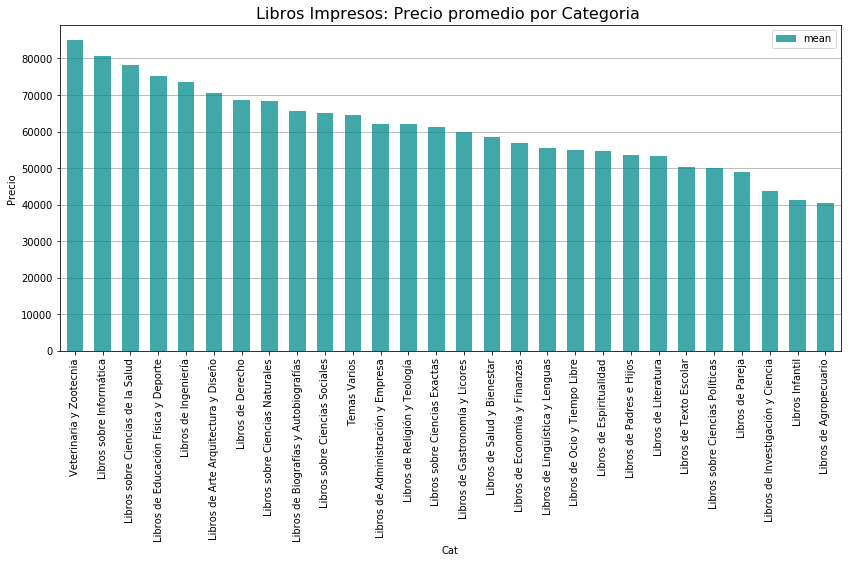

In [327]:
xl.plot.bar(figsize=[14,6], facecolor='darkcyan', alpha=0.75, zorder=3, width=.6)
plt.grid(axis='y',zorder=0)
plt.ylabel('Precio')
plt.title('Libros Impresos: Precio promedio por Categoria ', fontsize=16);

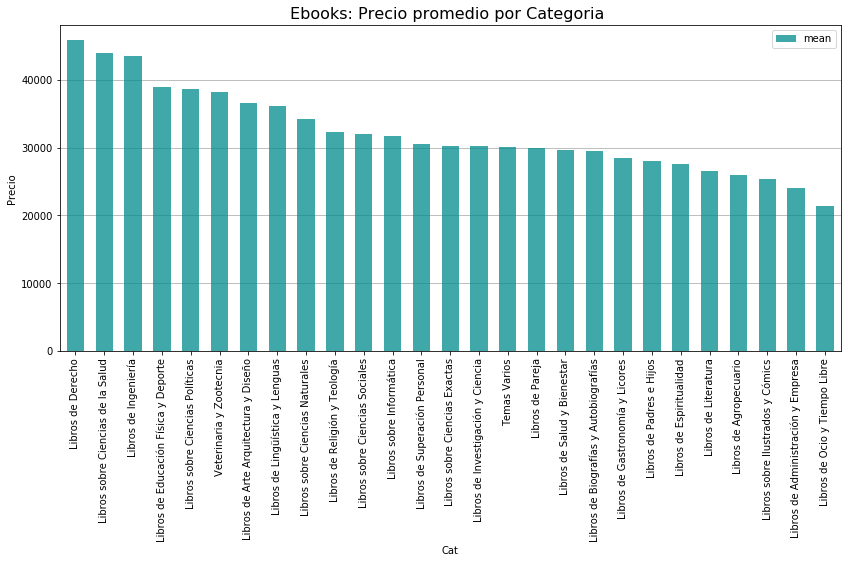

In [305]:
xe.plot.bar(figsize=[14,6], facecolor='darkcyan', alpha=0.75, zorder=3,  width=.6)
plt.grid(axis='y',zorder=0)
plt.ylabel('Precio')
plt.title('Ebooks: Precio promedio por Categoria ', fontsize=16);